In [1]:
import numpy as np
import pandas as pd
import linearsolve as ls
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

pd.plotting.register_matplotlib_converters()

# Class 16: Introduction to New-Keynesian Business Cycle Modeling

In this notebook, we will briefly explore US macroeconomic data suggesting that, contrary to the assumptions of most RBC models, there is in fact a relationship between real and nominal quantities over the business cycle. Then we will use `linearsolve` to compute impulse responses of output, inflation, and the nominal interest rate to a monetary policy shock in the New-Keynesian model.

## Data

The file `business_cycle_data_actual_trend_cycle.csv`, available at https://github.com/letsgoexploring/econ126/raw/master/Data/Csv/business_cycle_data_actual_trend_cycle.csv, contains actual and trend data for real GDP per capita, real consumption per capita, real investment per capita, real physical capital per capita, TFP, hours per capita, the rea money supply (M2), (nominal) interest rate on 3-month T-bills, the PCE inflation rate, and the unemployment rate; each at quarterly frequency. The GDP, consumption, investment, capital, and money supply data are in terms of 2012 dollars. Hours is measured as an index with the value in October 2012 set to 100.

In [2]:
# Read business_cycle_data_actual_trend.csv into a Pandas DataFrame with the first column set as the index and parse_dates=True
data = pd.read_csv('https://github.com/letsgoexploring/econ126/raw/master/Data/Csv/business_cycle_data_actual_trend_cycle.csv',index_col=0,parse_dates=True)

# Print the last five rows of the data
data.tail()

,gdp,gdp_trend,gdp_cycle,consumption,consumption_trend,consumption_cycle,investment,investment_trend,investment_cycle,hours,...,real_m2_cycle,t_bill_3mo,t_bill_3mo_trend,t_bill_3mo_cycle,pce_inflation,pce_inflation_trend,pce_inflation_cycle,unemployment,unemployment_trend,unemployment_cycle
2018-07-01,72.589059,72.376813,0.002928,49.377099,49.228728,0.003009,12.887706,12.752714,0.010530,105.399877,...,-0.010409,0.020400,0.016665,0.003735,0.057662,0.045360,0.012303,0.037667,0.038054,-0.000388
2018-10-01,72.606447,72.672948,-0.000915,49.377294,49.441990,-0.001309,12.942796,12.825832,0.009078,105.435736,...,-0.015843,0.023167,0.018115,0.005051,0.046050,0.045643,0.000408,0.038000,0.036738,0.001262
2019-01-01,73.251081,72.970978,0.003831,49.529684,49.656456,-0.002556,13.135114,12.899000,0.018139,105.677466,...,-0.010384,0.023867,0.019566,0.004300,0.039181,0.045903,-0.006722,0.038667,0.035432,0.003234
2019-04-01,73.482233,73.270527,0.002885,49.967211,49.872074,0.001906,12.910780,12.972253,-0.004750,105.340443,...,-0.012074,0.023000,0.021015,0.001985,0.040987,0.046152,-0.005165,0.036333,0.034133,0.002201
2019-07-01,73.703609,73.571388,0.001796,50.218595,50.088709,0.002590,12.811444,13.045774,-0.018125,105.768114,...,-0.004615,0.019800,0.022462,-0.002662,0.039933,0.046396,-0.006463,0.036333,0.032835,0.003498


### Exercise: GDP and Inflation

Construct a plot of the cyclical components of GDP and inflation. 

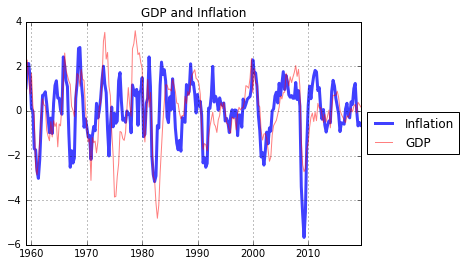

In [3]:
# Construct plot
plt.plot(data['pce_inflation_cycle']*100,alpha=0.75,lw=3,label='Inflation')
plt.plot(data['gdp_cycle']*100,c='r',alpha=0.5,label='GDP')
plt.grid()
plt.ylabel='Percent'
plt.title('GDP and Inflation')

# Place legend to right of figure. PROVIDED
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Exercise: GDP and the 3-Month T-Bill Rate

Construct a plot of the cyclical components of GDP and the 3-month T-bill rate. 

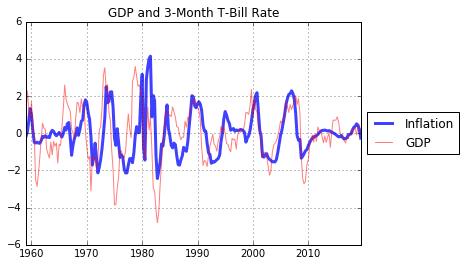

In [4]:
# Construct plot
plt.plot(data['t_bill_3mo_cycle']*100,alpha=0.75,lw=3,label='Inflation')
plt.plot(data['gdp_cycle']*100,c='r',alpha=0.5,label='GDP')
plt.grid()
plt.ylabel='Percent'
plt.title('GDP and 3-Month T-Bill Rate')

# Place legend to right of figure. PROVIDED
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Correlations Between GDP, Inflation, and 3-Month T-Bill Rate

Compute the coefficients of corrrelation between GDP, inflation, and the 3-month T-bill rate.

In [5]:
data[['gdp_cycle','pce_inflation_cycle','t_bill_3mo_cycle']].corr()

,gdp_cycle,pce_inflation_cycle,t_bill_3mo_cycle
gdp_cycle,1.000000,0.553497,0.407666
pce_inflation_cycle,0.553497,1.000000,0.241685
t_bill_3mo_cycle,0.407666,0.241685,1.000000


Strong (but not perfect!) correlations between GDP and inflation and GDP and the T-bill rate suggest link between nominal and real quantities over the business cycle that should be exaplined by business cycle theory.

## The New-Keynesian Model

The most basic version of the New-Keynesian Model can be expressed as:

\begin{align}
y_t & = E_t y_{t+1}  - \left( r_{t} - \bar{r}\right) + g_t\\
i_{t} & = r_{t} + E_t \pi_{t+1}\\
i_{t} & = \bar{r} + \pi^T + \phi_{\pi}\big(\pi_t - \pi^T\big) + \phi_{y}\big(y_t - \bar{y}\big) + v_t\\
\pi_t -\pi^T & = \beta \left( E_t\pi_{t+1} - \pi^T\right)  + \kappa (y_t -\bar{y})+ u_t,
\end{align}

where: $y_t$ is (log) output, $r_t$ is the real interest rate, $i_t$ is the nominal interest rate, $\pi_t$ is the rate of inflation between periods $t-1$ and $t$, $\bar{r}$ is the long-run average real interest rate or the *natural rate of interest*, $\beta$ is the household's subjective discount factor, and $\pi^T$ is the central bank's inflation target. The coeffieints $\phi_{\pi}$ and $\phi_{y}$ reflect the degree of intensity to which the central bank *endogenously* adjusts the nominal interest rate in response to movements in inflation and output.

The variables $g_t$, $u_t$, and $v_t$ represent exogenous shocks to aggregate demand, inflation, and monetary policy. They follow AR(1) processes:

\begin{align}
g_{t+1} & = \rho_g g_{t} + \epsilon^g_{t+1}\\
u_{t+1} & = \rho_u u_{t} + \epsilon^u_{t+1}\\
v_{t+1} & = \rho_v v_{t} + \epsilon^v_{t+1}.
\end{align}

The goal is to compute impulse responses in the model to a one percent exogenous increase in the nominal interest rate. We will use the following parameterization:

| $\bar{y}$ | $\beta$ | $\bar{r}$    | $\kappa$ | $\pi^T$ | $\phi_{\pi}$ | $\phi_y$ | $\rho_g$ | $\rho_u$ | $\rho_v$ | 
|-----------|---------|--------------|----------|---------|--------------|----------|----------|----------|---------|
| 0         | 0.995    | $-\log\beta$ | 0.1      | 0.02/4    | 1.5          | 0.5/4    | 0.5      | 0.5      | 0.5     |

In [6]:
# Create a variable called 'parameters' that stores the model parameter values in a Pandas Series
parameters = pd.Series()
parameters['y_bar'] = 0
parameters['beta'] = 0.995
parameters['r_bar'] = -np.log(parameters.beta)
parameters['kappa'] = 0.1
parameters['pi_T'] = 0.02/4
parameters['phi_pi'] = 1.5
parameters['phi_y'] = 0.5/4
parameters['rho_g'] = 0.5
parameters['rho_u'] = 0.5
parameters['rho_v'] = 0.5

# Print the model's parameters
print(parameters)

y_bar     0.000000
beta      0.995000
r_bar     0.005013
kappa     0.100000
pi_T      0.005000
phi_pi    1.500000
phi_y     0.125000
rho_g     0.500000
rho_u     0.500000
rho_v     0.500000
dtype: float64


In [7]:
# Create variable called 'var_names' that stores the variable names in a list with state variables ordered first
var_names = ['g','u','v','y','pi','i','r']

# Create variable called 'shock_names' that stores an exogenous shock name for each state variable.
shock_names = ['e_g','e_u','e_v']

# Define a function that evaluates the equilibrium conditions of the model solved for zero. PROVIDED
def equilibrium_equations(variables_forward,variables_current,parameters):
    
    # Parameters. PROVIDED
    p = parameters
    
    # Current variables. PROVIDED
    cur = variables_current
    
    # Forward variables. PROVIDED
    fwd = variables_forward

    # IS equation
    is_equation = fwd.y - (cur.r -p.r_bar) + cur.g - cur.y
    
    # Fisher_equation
    fisher_equation = cur.r + fwd.pi - cur.i
    
    # Monetary policy
    monetary_policy = p.r_bar + p.pi_T + p.phi_pi*(cur.pi - p.pi_T) + p.phi_y*cur.y + cur.v - cur.i
    
    # Phillips curve
    phillips_curve = p.beta*(fwd.pi- p.pi_T) + p.kappa*cur.y + cur.u - (cur.pi-p.pi_T)
    
    # Demand process
    demand_process = p.rho_g*cur.g - fwd.g
    
    # Monetary policy process
    monetary_policy_process = p.rho_v*cur.v - fwd.v
    
    # Inflation process
    inflation_process = p.rho_u*cur.u - fwd.u
    
    
    # Stack equilibrium conditions into a numpy array
    return np.array([
            is_equation,
            fisher_equation,
            monetary_policy,
            phillips_curve,
            demand_process,
            monetary_policy_process,
            inflation_process
        ])

# Initialize the model into a variable named 'nk_model'
nk_model = ls.model(equations = equilibrium_equations,
                 n_states=3,
                 var_names=var_names,
                 shock_names=shock_names,
                 parameters = parameters)

In [8]:
# Compute the steady state numerically using .compute_ss() method of nk_model
guess = [0,0,0,0,0.01,0.01,0.01]
nk_model.compute_ss(guess)

# Print the computed steady state
print(nk_model.ss)

g     1.832559e-36
u     3.518101e-35
v     4.196417e-36
y    -3.184980e-20
pi    5.000000e-03
i     1.001254e-02
r     5.012542e-03
dtype: float64


In [9]:
# Find the log-linear approximation around the non-stochastic steady state and solve using .approximate_and_solve() method of nk_model
# set argumement 'log_linear' to False because the model is already log-linear.
nk_model.approximate_and_solve(log_linear=False)

print(nk_model.approximated())

Linear equilibrium conditions:

       y[t+1|t] = -g[t]+y[t]+r[t]

      pi[t+1|t] = i[t]-r[t]

              0 = -v[t]-0.125·y[t]-1.5·pi[t]+i[t]

0.995·pi[t+1|t] = -u[t]-0.1·y[t]+pi[t]

        -g[t+1] = -0.5·g[t]

        -v[t+1] = -0.5·v[t]

        -u[t+1] = -0.5·u[t]


### Impulse Responses

Compute a 21 period impulse response of the model's variables to a 0.01/4 unit shock to the exogenous component of  monetary policy ($v_t$) in period 5.

In [10]:
# Compute impulse responses
nk_model.impulse(T=21,t0=5,shocks=[0,0,0.01/4])

# Print the first 10 rows of the computed impulse responses to the monetary policy shock
print(nk_model.irs['e_v'].head(10))

      e_v             g    u         v         y        pi         i         r
0  0.0000  0.000000e+00  0.0  0.000000  0.000000  0.000000  0.000000  0.000000
1  0.0000  0.000000e+00  0.0  0.000000  0.000000  0.000000  0.000000  0.000000
2  0.0000  0.000000e+00  0.0  0.000000  0.000000  0.000000  0.000000  0.000000
3  0.0000  0.000000e+00  0.0  0.000000  0.000000  0.000000  0.000000  0.000000
4  0.0000  0.000000e+00  0.0  0.000000  0.000000  0.000000  0.000000  0.000000
5  0.0025  0.000000e+00  0.0  0.002500 -0.003034 -0.000604  0.001215  0.001517
6  0.0000 -3.469447e-19  0.0  0.001250 -0.001517 -0.000302  0.000608  0.000758
7  0.0000 -3.469447e-19  0.0  0.000625 -0.000758 -0.000151  0.000304  0.000379
8  0.0000 -2.602085e-19  0.0  0.000313 -0.000379 -0.000075  0.000152  0.000190
9  0.0000 -1.734723e-19  0.0  0.000156 -0.000190 -0.000038  0.000076  0.000095


Plot the computed impulses responses of the nominal interest rate, the real interest rate, output, and inflation. Express inflation and interest rates in *annualized* (e.g., multiplied by 4) terms.

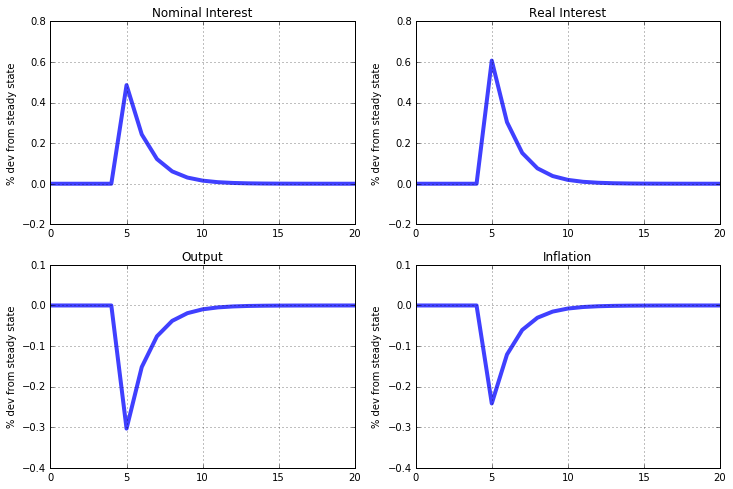

In [11]:
# Create figure. PROVIDED
fig = plt.figure(figsize=(12,8))

# Create upper-left axis. PROVIDED
ax1 = fig.add_subplot(2,2,1)
# Create upper-right axis. PROVIDED
ax2 = fig.add_subplot(2,2,2)
# Create lower-left axis. PROVIDED
ax3 = fig.add_subplot(2,2,3)
# Create lower-right axis. PROVIDED
ax4 = fig.add_subplot(2,2,4)

# Set axis 1 ylabel
ax1.set_ylabel('% dev from steady state')
# Set axis 2 ylabel
ax2.set_ylabel('% dev from steady state')
# Set axis 3 ylabel
ax3.set_ylabel('% dev from steady state')
# Set axis 4 ylabel
ax4.set_ylabel('% dev from steady state')

# Set axis 1 limits 
ax1.set_ylim([-0.2,0.8])
# Set axis 2 limits
ax2.set_ylim([-0.2,0.8])
# Set axis 3 limits
ax3.set_ylim([-0.4,0.1])
# Set axis 4 limits
ax4.set_ylim([-0.4,0.1])

# Plot the nominal interest rate, real interest rate, output, and inflation
(nk_model.irs['e_v']['i']*400).plot(ax=ax1,lw=4,alpha=0.75,title='Nominal Interest',grid=True)
(nk_model.irs['e_v']['r']*400).plot(ax=ax2,lw=4,alpha=0.75,title='Real Interest',grid=True)
(nk_model.irs['e_v']['y']*100).plot(ax=ax3,lw=4,alpha=0.75,title='Output',grid=True)
(nk_model.irs['e_v']['pi']*400).plot(ax=ax4,lw=4,alpha=0.75,title='Inflation',grid=True)